# Data Science UCS538 DASHBOARD Project
                                   To Dr. Geeta Kasana 
                                   By Karan Singh Pathania 
                                   101903072
                                   3C03

### In this notebook a visualisation dashboard has been created using python and some inbuilt libraries .
### Erling Braut Haaland a prolific goalscorer is a Norwegian professional footballer who plays as a striker for German Bundesliga club Borussia Dortmund and the Norway national team.  A dashboard has been created for Erling Haaland and his goalscoring . 
### We’ll be scraping data from Understat and Fbref, and then using this data to plot shot maps and one goal vs expected goals scatterplot within the dashboard.




## Data taken from https://understat.com/player/8260 and https://fbref.com/en/comps/Big5/shooting/players/Big-5-European-Leagues-Stats

## Reference taken from https://www.youtube.com/watch?v=IsR5FrjNmro and https://mplsoccer.readthedocs.io/en/latest/
        

In [1]:
# Firstly we will import all the necessary libraries 
import requests
from bs4 import BeautifulSoup as soup
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

In [2]:
# HAALAND'S PLAYER ID IN UNDERSTAT IS 8260 . Understat website provides us with the statistics of top european footballers . 
# A link to Erling HAALAND stats has been provided above . 
url ='https://understat.com/player/8260'
# Now, we will get down to scraping data from Understat. 
#For this, we will need the requests, BeautifulSoup, JSON and pandas packages.
html = requests.get(url)
parse_soup = soup(html.content,'lxml')
scripts = parse_soup.find_all('script')
strings = scripts[3].string
ind_start = strings.index("('")+2
ind_end = strings.index("')")
json_data = strings[ind_start:ind_end]
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)
x = []
y = []
xg = []
result = []
season = []
for i,_ in enumerate(data):
    for key in data[i]:
        if key=='X':
            x.append(data[i][key])
        if key=='Y':
            y.append(data[i][key])
        if key=='xG':
            xg.append(data[i][key])
        if key=='result':
            result.append(data[i][key])
        if key=='season':
            season.append(data[i][key])
columns = ['X','Y','xG','Result','Season']
df_understat = pd.DataFrame([x, y, xg, result, season], index=columns)
df_understat = df_understat.T
df_understat = df_understat.apply(pd.to_numeric,errors='ignore')

In [3]:
#Therefore, we are able to create a data frame containing the shot location, shot result, the xG(expected goals) and Season.
#However, a quick look at the database shows that our x and y are scaled between 0 and 1.
print(df_understat)

         X      Y        xG       Result  Season
0    0.888  0.666  0.079333         Goal    2019
1    0.980  0.489  0.920621         Goal    2019
2    0.883  0.347  0.322831         Goal    2019
3    0.886  0.639  0.119181  BlockedShot    2019
4    0.955  0.495  0.746641         Goal    2019
..     ...    ...       ...          ...     ...
155  0.807  0.501  0.077159    SavedShot    2021
156  0.955  0.472  0.612741         Goal    2021
157  0.919  0.645  0.107079  MissedShots    2021
158  0.901  0.655  0.070641         Goal    2021
159  0.926  0.697  0.052674  BlockedShot    2021

[160 rows x 5 columns]


In [4]:
#To address this issue, we will scale both the X and Y columns to a 100,
#as the Opta pitch we will be using later utilises 100 x 100 pitches.
df_understat['X'] = df_understat['X'].apply(lambda x:x*100)
df_understat['Y'] = df_understat['Y'].apply(lambda x:x*100)
# Now we have scrapped the understat site , further we will scrap the Fbref website
print(df_understat)

             X          Y        xG       Result  Season
0    88.800003  66.599998  0.079333         Goal    2019
1    98.000000  48.900002  0.920621         Goal    2019
2    88.300003  34.700001  0.322831         Goal    2019
3    88.599998  63.900002  0.119181  BlockedShot    2019
4    95.500000  49.500000  0.746641         Goal    2019
..         ...        ...       ...          ...     ...
155  80.699997  50.099998  0.077159    SavedShot    2021
156  95.500000  47.200001  0.612741         Goal    2021
157  91.900002  64.500000  0.107079  MissedShots    2021
158  90.099998  65.500000  0.070641         Goal    2021
159  92.599998  69.699997  0.052674  BlockedShot    2021

[160 rows x 5 columns]


In [5]:
def readfromhtml(filepath):
    df = pd.read_html(filepath)[0]
    #print(df)
    column_lst = list(df.columns)
    
    for index in range(len(column_lst)):
        column_lst[index] = column_lst[index][1]

    df.columns = column_lst

    
    df.drop(df[df['Player'] == 'Player'].index, inplace=True)
    df = df.fillna('0')
    df.set_index('Rk', drop=True, inplace=True)
    try:
        df['Comp'] = df['Comp'].apply(lambda x: ' '.join(x.split()[1:]))
        df['Nation'] = df['Nation'].astype(str)
        df['Nation'] = df['Nation'].apply(lambda x: x.split()[-1])
    except:
        print('Error in uploading file:' + filepath)
    finally:
        df = df.apply(pd.to_numeric, errors='ignore')
        return df

In [6]:
df_fbref = readfromhtml('https://fbref.com/en/comps/Big5/shooting/players/Big-5-European-Leagues-Stats')



In [7]:
df_fbref


,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Gls,Sh,...,Dist,FK,PK,PKatt,xG,npxG,npxG/Sh,G-xG,np:G-xG,Matches
Rk,,,,,,,,,,,,,,,,,,,,,
1,Max Aarons,ENG,DF,Norwich City,Premier League,21-339,2000,15.0,0,9,...,20.2,0,0,0,0.6,0.6,0.06,-0.6,-0.6,Matches
2,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,34-072,1987,17.0,1,11,...,17.1,0,0,0,0.6,0.6,0.05,0.4,0.4,Matches
3,Salis Abdul Samed,GHA,MF,Clermont Foot,Ligue 1,21-258,2000,14.7,0,3,...,25.0,0,0,0,0.1,0.1,0.04,-0.1,-0.1,Matches
4,Laurent Abergel,FRA,MF,Lorient,Ligue 1,28-311,1993,16.0,0,15,...,21.0,0,0,0,1.5,1.5,0.10,-1.5,-1.5,Matches
5,Charles Abi,FRA,FW,Saint-Étienne,Ligue 1,21-241,2000,0.5,0,0,...,0.0,0,0,0,0.0,0.0,0.00,0.0,0.0,Matches
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425,Martín Zubimendi,ESP,MF,Real Sociedad,La Liga,22-310,1999,12.1,0,4,...,17.9,0,0,0,0.4,0.4,0.09,-0.4,-0.4,Matches
2426,Szymon Żurkowski,POL,MF,Empoli,Serie A,24-075,1997,7.2,2,17,...,22.2,0,0,0,1.0,1.0,0.06,1.0,1.0,Matches
2427,Martin Ødegaard,NOR,MF,Arsenal,Premier League,22-357,1998,9.2,3,10,...,21.4,4,0,0,0.8,0.8,0.08,2.2,2.2,Matches


### Now the fbref website has also been scrapped and our data is ready . Now we can finally move on to creating the dashboard . 
### NOW WE NEED TO DOWNLOAD TWO PACKAGES MPLSOCCER AND HIGHLIGHT-TEXT
### The documentation for mplsoccer is at https://mplsoccer.readthedocs.io/en/latest/gallery/index.html while that for highlight-text is at https://pypi.org/project/highlight-text/#:~:text=the%20examples%20below.-,Use,the%20figure%20in%20figure%20coordinates.
### In case those packages aren’t installed in your environment, just run the following commands.

In [8]:
!pip install mplsoccer
#pip install mplsoccer

#mplsoccer is a Python library for plotting soccer/football charts in Matplotlib and loading StatsBomb open-data.


In [9]:
!pip install highlight-text
#pip install highlight-text

#The HighlightText package provides a natural way to specify substrings that should 
#be highlighted and individual font properties that should be used for each of the highlights.

In [10]:
import mplsoccer

In [11]:
from highlight_text import ax_text,fig_text

In [12]:
#Now for changing the default colours and fonts of matplotlib , i have used Matplotlib’s rcParams
#You can check the color codes at https://htmlcolorcodes.com/color-picker/

background = '#D6DBD9'
text_color = 'black'
mpl.rcParams['xtick.color']=text_color
mpl.rcParams['ytick.color']=text_color
mpl.rcParams['text.color']=text_color
mpl.rcParams['font.family']='Candara'
mpl.rcParams['legend.fontsize'] = 15

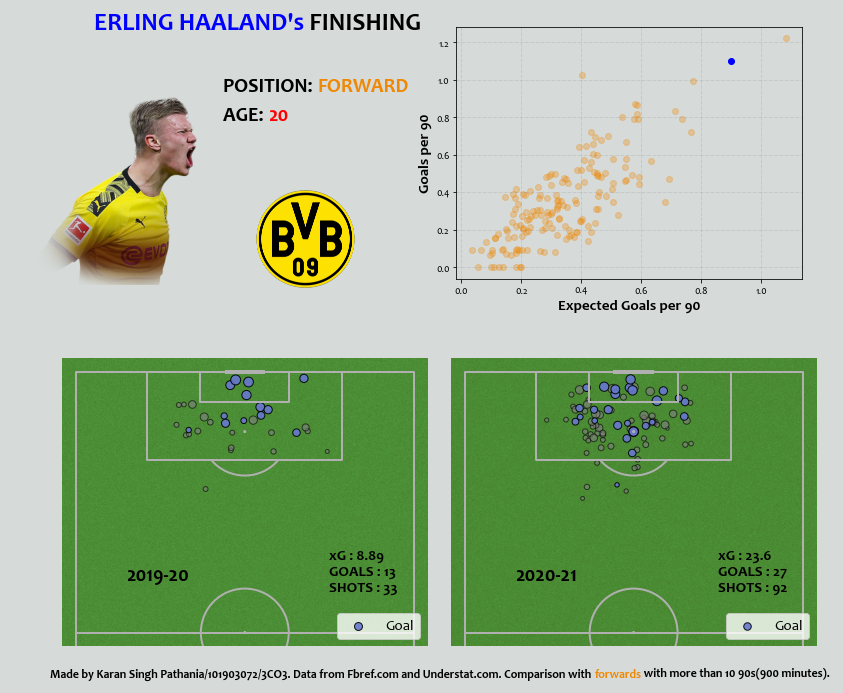

In [13]:
# SETTING UP THE AXES
fig, ax = plt.subplots(figsize=(12,10))
ax.axis('off')
fig.set_facecolor(background)
#This code executes and gives us a plain background with hex colour #D6DBD9

#The add_axes method of fig adds and axes in that region of the fig area.
#The first two parameters in the list correspond to the (0,0) location of the axis while the next two correspond to the
#length and width. 
#We will also be using a Vertical Pitch rather than the default Horizontal version, and only one half of it.
#SETTING UP THE MPL AXIS FOR THE FIRST SEASON
pitch = mplsoccer.VerticalPitch(half=True,pitch_type='opta',line_zorder=3,pitch_color='grass')
ax_opta1 = fig.add_axes((0.05, 0.06, 0.45, 0.4))
ax_opta1.patch.set_facecolor(background)
pitch.draw(ax=ax_opta1)




#we will now plot the other shots too.
#We will use a different colour and make them slightly more transparent by reducing the alpha. 

#PLOTTING OTHER SHOTS
df_fil = df_understat.loc[df_understat['Season']==2019]

pitch.scatter(df_fil[df_fil['Result']!='Goal']['X'],df_fil[df_fil['Result']!='Goal']['Y'], 
              s=np.sqrt(df_fil[df_fil['Result']!='Goal']['xG'])*100, marker='o', alpha=0.6,
              edgecolor='black', facecolor='grey', ax=ax_opta1)

# We use the scatter function after filtering the Understat Dataframe for the 2019 Season and for those shots that
#resulted in a goal.
#The size of the shots is depended on the xG of that particular shot.
#NOW PLOTTING THE GOALS IN THE 2019-20 SEASON
pitch.scatter(df_fil[df_fil['Result']=='Goal']['X'],df_fil[df_fil['Result']=='Goal']['Y'], 
              s=np.sqrt(df_fil[df_fil['Result']=='Goal']['xG'])*100, marker='o', alpha=0.9,
              edgecolor='black', facecolor='#6778d0', ax=ax_opta1, label='Goal')


#Adding a label. We will add a legend for the goals to make it clearer.
# ADDING THE LEGEND
ax_opta1.legend(loc='lower right').get_texts()[0].set_color("black")

#Now we will add some additional information to this graph, such as total shots, goals, etc.
ax_opta1.text(25,61,'GOALS : '+str(len(df_fil[df_fil['Result']=='Goal'])), weight='bold', size=15)
ax_opta1.text(25,64,f"xG : {round(sum(df_fil['xG']),2)}", weight='bold', size=15)
ax_opta1.text(25,58,'SHOTS : '+str(len(df_fil)), weight='bold', size=15)
ax_opta1.text(85, 60, '2019-20', weight='bold', size=20)

# DOING THE SAME FOR THE 20-21 SEASON TOO
ax_opta2 = fig.add_axes((0.50, 0.06, 0.45, 0.4))
ax_opta2.patch.set_facecolor(background)
pitch.draw(ax=ax_opta2)



#PLOTTING OTHER SHOTS
df_fil = df_understat.loc[df_understat['Season']==2020]

pitch.scatter(df_fil[df_fil['Result']!='Goal']['X'],df_fil[df_fil['Result']!='Goal']['Y'], 
              s=np.sqrt(df_fil[df_fil['Result']!='Goal']['xG'])*100, marker='o', alpha=0.6,
              edgecolor='black', facecolor='grey', ax=ax_opta2)

#NOW PLOTTING THE GOALS IN THE 2019-20 SEASON
pitch.scatter(df_fil[df_fil['Result']=='Goal']['X'],df_fil[df_fil['Result']=='Goal']['Y'], 
              s=np.sqrt(df_fil[df_fil['Result']=='Goal']['xG'])*100, marker='o', alpha=0.9,
              edgecolor='black', facecolor='#6778d0', ax=ax_opta2, label='Goal')

# ADDING THE LEGEND
ax_opta2.legend(loc='lower right').get_texts()[0].set_color("black")

ax_opta2.text(25,61,'GOALS : '+str(len(df_fil[df_fil['Result']=='Goal'])), weight='bold', size=15)
ax_opta2.text(25,64,f"xG : {round(sum(df_fil['xG']),2)}", weight='bold', size=15)
ax_opta2.text(25,58,'SHOTS : '+str(len(df_fil)), weight='bold', size=15)
ax_opta2.text(85, 60, '2020-21', weight='bold', size=20)

# NOW PLOTTING THE SCATTERPLOT
ax_scatter = fig.add_axes([0.52,0.57,0.4,0.35])
ax_scatter.patch.set_facecolor(background)

#plotting the goals vs expected goals plot. 
#filter the Fbref data frame with a minimum no of minutes played and to a certain position.
# SETTING UP THE X AND Y OF THE SCATTERPLOT
no_90s = 10
df_fil = df_fbref[df_fbref['90s']>=no_90s]
df_fil = df_fil[df_fil['Pos'].apply(lambda x: x in ['FW','MF,FW','FW,MF'])]

x,y = (df_fil['xG']/df_fil['90s']).to_list(), (df_fil['Gls']/df_fil['90s']).to_list()

ax_scatter.scatter(x,y,alpha=0.3,c='#EF8804')

# NOW FILTERING ERLING HAALAND'S DATA
df_player = df_fil[df_fil['Player']=='Erling Haaland']

ax_scatter.scatter(df_player['xG']/df_player['90s'], df_player['Gls']/df_player['90s'], c='blue')


# ADDING FINISHING TOUCHES TO THE SCATTERPLOT
ax_scatter.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.4)
ax_scatter.set_xlabel('Expected Goals per 90', fontdict = {'fontsize':15, 'weight' : 'bold', 'color':text_color})
ax_scatter.scatter(0.9,1.1,c='blue')
ax_scatter.set_ylabel('Goals per 90', fontdict = dict(fontsize = 15, weight = 'bold',color=text_color))

#ADDING HAALAND'S IMAGE
ax_player = fig.add_axes([0,0.43,0.25,0.45])
ax_player.axis('off')
im = plt.imread('haaland.png')
ax_player.imshow(im)

# ADDING TITLES AND INFO
fig_text(0.1,0.94,"<ERLING HAALAND's> FINISHING",weight='heavy', size=25, highlight_textprops=[{'color':'blue'}])
fig_text(0.25,0.85,'POSITION: <FORWARD>',weight='bold', size=20, highlight_textprops=[{'color':'#EF8804'}])
fig_text(0.25,0.81,'AGE: <20>',weight='bold', size=20, highlight_textprops=[{'color':'red'}])

# ADDING CLUB LOGO
ax_team = fig.add_axes([0.27,0.55,0.15,0.15])
ax_team.axis('off')
im = plt.imread('bvb.png')
ax_team.imshow(im)

# ADDING A FOOTER
fig_text(0.05,0.03,'Made by Karan Singh Pathania/101903072/3CO3. Data from Fbref.com and Understat.com. Comparison with <forwards>'+
        ' with more than '+str(no_90s)+' 90s('+str(no_90s*90)+' minutes).',
        size=12, highlight_textprops=[{'color':'#EF8804'}], weight = 'bold')

#plt.savefig('Haaland_viz.png',dpi=300,facecolor=background)